In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# 1. Data Loading
# ============================
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# ============================
# 2. Merge studentAssessment & studentInfo
#    to get code_module & code_presentation
# ============================
df_studentAssessment_expanded = pd.merge(
    df_studentAssessment,
    df_studentInfo[["id_student", "code_module", "code_presentation"]],
    on="id_student",
    how="left"
)

# Now merge with assessments to get 'assessment_type'
df_studentAssessment_expanded = pd.merge(
    df_studentAssessment_expanded,
    df_assessments[["id_assessment", "assessment_type", "code_module", "code_presentation"]],
    on=["id_assessment", "code_module", "code_presentation"],
    how="left"
)

# ============================
# 3. Create 2 Assessment Features
#    (Avg_TMA_Score & Exam_Score)
# ============================
# Filter TMA vs. Exam
df_avg_tma = (
    df_studentAssessment_expanded[df_studentAssessment_expanded["assessment_type"] == "TMA"]
    .groupby(["id_student", "code_module", "code_presentation"])["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "Avg_TMA_Score"})
)

df_exam_score = (
    df_studentAssessment_expanded[df_studentAssessment_expanded["assessment_type"] == "Exam"]
    .groupby(["id_student", "code_module", "code_presentation"])["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "Exam_Score"})
)

# Merge TMA & Exam into a single assessment-features table
df_assess_feats = pd.merge(
    df_avg_tma,
    df_exam_score,
    on=["id_student", "code_module", "code_presentation"],
    how="outer"
).fillna(0)

# ============================
# 4. Create 40 VLE Features
#    (20 sum of clicks + 20 visits)
# ============================
# Merge studentVle with vle to get activity_type
df_studentVle_expanded = pd.merge(
    df_studentVle,
    df_vle[["id_site", "activity_type", "code_module", "code_presentation"]],
    on=["id_site", "code_module", "code_presentation"],
    how="left"
)

# (a) sum_clicks per (id_student, code_module, code_presentation, activity_type)
pivot_sum = (
    df_studentVle_expanded
    .groupby(["id_student", "code_module", "code_presentation", "activity_type"])["sum_click"]
    .sum()
    .unstack("activity_type", fill_value=0)
)
pivot_sum.columns = [f"sum_clicks_{col}" for col in pivot_sum.columns]
pivot_sum.reset_index(inplace=True)

# (b) number_of_visits per activity_type
# Define a "visit" as any row with sum_click > 0
df_studentVle_expanded["visit"] = df_studentVle_expanded["sum_click"].apply(lambda x: 1 if x > 0 else 0)
pivot_visits = (
    df_studentVle_expanded
    .groupby(["id_student", "code_module", "code_presentation", "activity_type"])["visit"]
    .sum()
    .unstack("activity_type", fill_value=0)
)
pivot_visits.columns = [f"visits_{col}" for col in pivot_visits.columns]
pivot_visits.reset_index(inplace=True)

# Merge sum_clicks & visits into one DataFrame
df_vle_feats = pd.merge(
    pivot_sum, 
    pivot_visits, 
    on=["id_student", "code_module", "code_presentation"],
    how="outer"
).fillna(0)

# ============================
# 5. Merge Demographics + Assessments + VLE
# ============================
# Keep 8 demographic columns from studentInfo:
#   gender, region, highest_education, imd_band, age_band, disability, studied_credits, num_of_prev_attempts
df_merged = pd.merge(
    df_studentInfo,
    df_assess_feats,    # (Avg_TMA_Score, Exam_Score)
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_vle_feats,       # 40 VLE columns
    on=["id_student", "code_module", "code_presentation"],
    how="left"
).fillna(0)

# ============================
# 6. Create Binary Target: Withdrawn vs. Not Withdrawn
# ============================
# Instead of filtering out withdrawn students, we keep all records.
# target = 1 if final_result is "Withdrawn", else 0.
df_merged["target"] = df_merged["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# ============================
# 7. Select Final Columns (50 features + target)
# ============================
# 8 Demographic Features
demographic_cols = [
    "gender", "region", "highest_education", "imd_band",
    "age_band", "disability", "studied_credits", "num_of_prev_attempts"
]

# 2 Assessment Features
assessment_cols = ["Avg_TMA_Score", "Exam_Score"]

# 40 VLE Features = all pivot columns except the merge keys
all_vle_cols = set(df_vle_feats.columns) - {"id_student", "code_module", "code_presentation"}
vle_cols = list(all_vle_cols)  # converting set to list

# Final feature list
feature_cols = demographic_cols + assessment_cols + vle_cols

# Keep ID columns for reference if needed
id_cols = ["id_student", "code_module", "code_presentation"]

# Build final DataFrame
df_final = df_merged[id_cols + feature_cols + ["target"]].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))
print("Number of features (excluding target):", len(feature_cols))

features = [col for col in df_final.columns]
print("Using the following feature columns:")
print(features)


   id_student code_module code_presentation gender                region  \
0       11391         AAA             2013J      M   East Anglian Region   
1       28400         AAA             2013J      F              Scotland   
2       30268         AAA             2013J      F  North Western Region   
3       31604         AAA             2013J      F     South East Region   
4       32885         AAA             2013J      F  West Midlands Region   
5       38053         AAA             2013J      M                 Wales   
6       45462         AAA             2013J      M              Scotland   
7       45642         AAA             2013J      F  North Western Region   
8       52130         AAA             2013J      F   East Anglian Region   
9       53025         AAA             2013J      M          North Region   

             highest_education imd_band age_band disability  studied_credits  \
0             HE Qualification  90-100%     55<=          N              240   
1  

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ------------------------
# Cleaning functions
# ------------------------
def clean_imd_band(x):
    mapping = {
        '0-10%': 0, '10-20': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4,
        '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9
    }
    return mapping.get(x, np.nan)

def clean_age_band(x):
    mapping = {
        '0-35': 0,
        '35-55': 1,
        '55<=': 2
    }
    return mapping.get(x, np.nan)

def clean_highest_education(x):
    mapping = {
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    }
    return mapping.get(x, np.nan)

def clean_disability(x):
    mapping = {'Y': 1, 'N': 0}
    return mapping.get(x, np.nan)

def clean_gender(x):
    mapping = {'M': 0, 'F': 1}
    return mapping.get(x, np.nan)

# ------------------------
# Assume df_merged is already created from merging your various sources.
# ------------------------
# Apply cleaning functions to known columns
df_merged["imd_band"] = df_merged["imd_band"].apply(clean_imd_band)
df_merged["age_band"] = df_merged["age_band"].apply(clean_age_band)
df_merged["highest_education"] = df_merged["highest_education"].apply(clean_highest_education)
df_merged["disability"] = df_merged["disability"].apply(clean_disability)
df_merged["gender"] = df_merged["gender"].apply(clean_gender)

# 'region' is categorical. We convert it to string and label encode it.
region_encoder = LabelEncoder()
df_merged["region"] = df_merged["region"].astype(str)
df_merged["region"] = region_encoder.fit_transform(df_merged["region"])

# Ensure numeric columns are converted properly. Replace non-numeric with 0 if needed.
numeric_cols = ["studied_credits", "num_of_prev_attempts", "Avg_TMA_Score", "Exam_Score"]
for col in numeric_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').fillna(0)

# For the VLE pivoted columns (starting with 'sum_clicks_' or 'visits_'), ensure they are numeric.
vle_cols = [c for c in df_merged.columns if c.startswith("sum_clicks_") or c.startswith("visits_")]
for col in vle_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').fillna(0)

# ------------------------
# Create Binary Target for Withdrawn vs. Not Withdrawn
# ------------------------
# Instead of removing withdrawn records, we keep them all and set:
#   target = 1 if final_result is "Withdrawn", else 0.
df_merged["target"] = df_merged["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# ------------------------
# Select the Final 50 Features (8 Demographic, 2 Assessment, 40 VLE) plus IDs and target
# ------------------------
demographic_cols = [
    "gender", "region", "highest_education", "imd_band",
    "age_band", "disability", "studied_credits", "num_of_prev_attempts"
]
assessment_cols = ["Avg_TMA_Score", "Exam_Score"]
vle_feature_cols = [c for c in df_merged.columns if c.startswith("sum_clicks_") or c.startswith("visits_")]
feature_cols = demographic_cols + assessment_cols + vle_feature_cols

id_cols = ["id_student", "code_module", "code_presentation"]

df_final = df_merged[id_cols + feature_cols + ["target"]].copy()

# Check the final DataFrame structure
print("df_final columns:", df_final.columns)
print("Number of features (excluding target):", len(feature_cols))


df_final columns: Index(['id_student', 'code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'disability',
       'studied_credits', 'num_of_prev_attempts', 'Avg_TMA_Score',
       'Exam_Score', 'sum_clicks_dataplus', 'sum_clicks_dualpane',
       'sum_clicks_externalquiz', 'sum_clicks_folder', 'sum_clicks_forumng',
       'sum_clicks_glossary', 'sum_clicks_homepage', 'sum_clicks_htmlactivity',
       'sum_clicks_oucollaborate', 'sum_clicks_oucontent',
       'sum_clicks_ouelluminate', 'sum_clicks_ouwiki', 'sum_clicks_page',
       'sum_clicks_questionnaire', 'sum_clicks_quiz',
       'sum_clicks_repeatactivity', 'sum_clicks_resource',
       'sum_clicks_sharedsubpage', 'sum_clicks_subpage', 'sum_clicks_url',
       'visits_dataplus', 'visits_dualpane', 'visits_externalquiz',
       'visits_folder', 'visits_forumng', 'visits_glossary', 'visits_homepage',
       'visits_htmlactivity', 'visits_oucollaborate', 'visits_oucontent',
     

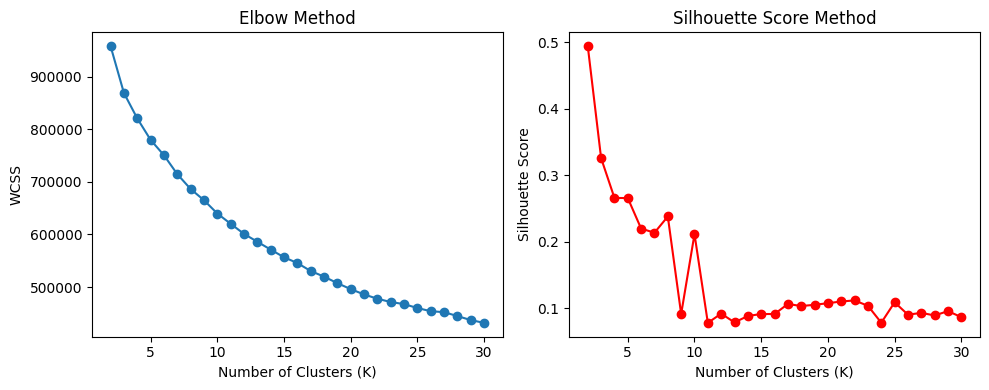

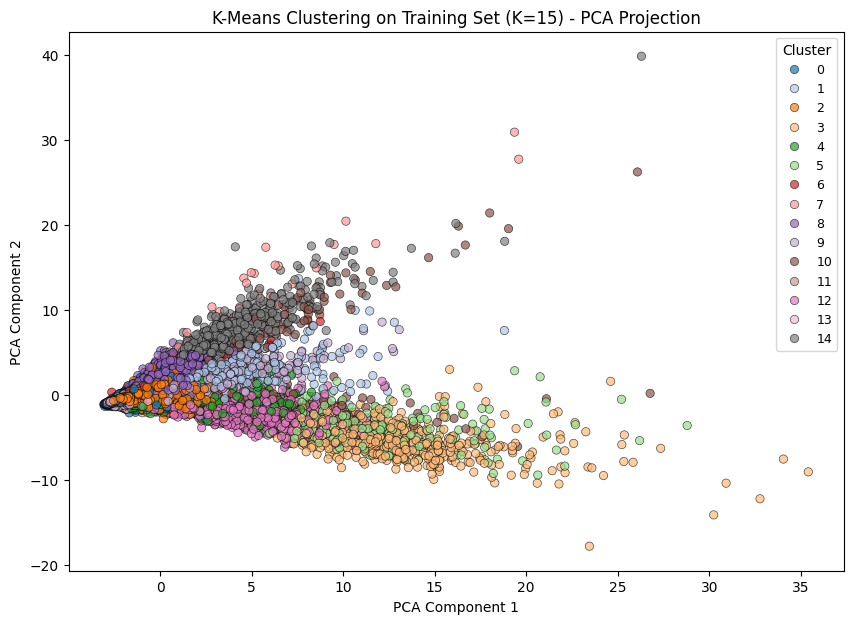

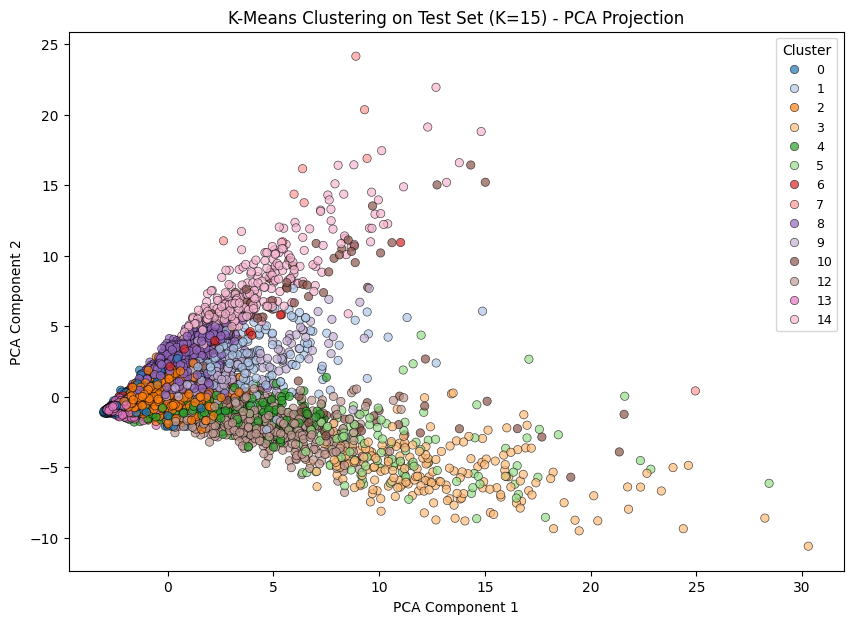

Cluster Means on Training Set:
           gender    region  highest_education  imd_band  age_band  \
Cluster                                                              
0        0.499769  5.990282           1.616844  3.910689  0.286904   
1        0.503922  5.631373           1.974510  5.113725  0.625490   
2        0.594564  5.971824           1.720733  4.359556  0.319287   
3        0.267308  5.688462           1.840385  5.130769  0.421154   
4        0.162667  6.056000           1.700000  4.477333  0.214667   
5        0.231884  5.840580           1.829710  4.760870  0.510870   
6        0.839506  5.543210           1.641975  3.691358  0.469136   
7        0.600000  5.360000           2.040000  5.000000  0.320000   
8        0.326741  5.960017           2.022356  5.229149  0.280739   
9        0.114251  5.699017           1.934889  5.353808  0.326781   
10       0.366667  5.290476           1.790476  4.971429  0.414286   
11       0.000000  3.666667           1.333333  2.666667  0

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ============================================
# Assume df_final is available from previous pipeline
# It contains id_student, code_module, code_presentation,
# 50 engineered features and a target column (Withdrawn vs. Not Withdrawn)
# ============================================
df = df_final.copy()

# For clustering, we want to use the engineered features.
# We'll drop the id columns and target from the features used for clustering.
X = df.drop(columns=["id_student", "code_module", "code_presentation", "target"])

# Optionally, keep the target for later evaluation
y = df["target"]

# ============================================
# Split the Data: Training & Test Sets
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create training and test DataFrames including the target (for evaluation if needed)
df_train = X_train.copy()
df_train['target'] = y_train
df_test = X_test.copy()
df_test['target'] = y_test

# ============================================
# Encode Categorical Variables
# ============================================
# Define categorical columns (adjust as necessary for your dataset)
categorical_cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band']

# Initialize and apply label encoders on training data, then transform test data
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le
    # Apply the same transformation to test set
    df_test[col] = le.transform(df_test[col])

# ============================================
# Standardize Features
# ============================================
# Fit scaler on training features (excluding the target) and transform both train and test sets
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns=['target']))
test_scaled = scaler.transform(df_test.drop(columns=['target']))

# ============================================
# Finding Optimal K (Elbow & Silhouette Methods) on the Training Set
# ============================================
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 30 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(train_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train_scaled, cluster_labels))

# Plot the Elbow Method results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")
plt.tight_layout()
plt.show()

# ============================================
# Applying K-Means with Optimal K on Training Data
# ============================================
optimal_k = 15  # Choose optimal K based on the above plots (adjust if needed)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_train['Cluster'] = kmeans.fit_predict(train_scaled)

# ============================================
# Assign Cluster Labels to Test Set
# ============================================
df_test['Cluster'] = kmeans.predict(test_scaled)

# ============================================
# Visualize Clusters Using PCA (Training Set)
# ============================================
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
df_train['PCA1'] = train_pca[:, 0]
df_train['PCA2'] = train_pca[:, 1]

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', 
    data=df_train, palette="tab20", alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering on Training Set (K={optimal_k}) - PCA Projection")
plt.legend(title="Cluster", fontsize=9)
plt.show()

# ============================================
# Optionally Visualize Test Set Clusters Using the Same PCA Transformation
# ============================================
test_pca = pca.transform(test_scaled)
df_test['PCA1'] = test_pca[:, 0]
df_test['PCA2'] = test_pca[:, 1]

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster',
    data=df_test, palette="tab20", alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering on Test Set (K={optimal_k}) - PCA Projection")
plt.legend(title="Cluster", fontsize=9)
plt.show()

# ============================================
# Display Cluster Statistics on the Training Set
# ============================================
print("Cluster Means on Training Set:")
print(df_train.groupby('Cluster').mean())


In [12]:
# ===================================================
# 3) Prepare for Modeling (Now We Have 'Cluster' + 'target')
# ===================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Ensure that the 'Cluster' feature is treated as categorical
df_train["Cluster"] = df_train["Cluster"].astype("category")
df_test["Cluster"] = df_test["Cluster"].astype("category")

# Exclude non-modeling columns:
# - 'id_student' is an identifier.
# - 'code_module' and 'code_presentation' are also identifiers.
# - 'PCA1' and 'PCA2' are only used for visualization.
exclude_for_model = ["id_student", "code_module", "code_presentation", "PCA1", "PCA2"]

# Select the final features from df_train (all columns not excluded)
final_features = [col for col in df_train.columns if col not in exclude_for_model]
print("Using final features:", final_features)

# X/y split: Separate features from target
X_train = df_train[final_features].drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test[final_features].drop(columns=["target"])
y_test = df_test["target"]

# One-hot encode categorical columns (e.g., 'Cluster') for modeling
categorical_cols_for_model = [
    c for c in X_train.columns if X_train[c].dtype.name in ["object", "category"]
]
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols_for_model, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols_for_model, drop_first=True)

# Align the encoded train and test sets to ensure they have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)

# Optionally, create sample weights based on module frequency if 'code_module' is present in the original data.
# (Note: since 'code_module' was dropped for modeling, we refer back to df_train before dropping.)
if "code_module" in df_train.columns:
    mod_counts = df_train["code_module"].value_counts()
    df_train["module_weight"] = df_train["code_module"].map(lambda x: 1.0 / mod_counts[x])
    sample_weights = df_train["module_weight"]
else:
    sample_weights = None

# Define models for classification
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion="entropy",
        max_depth=5,
        min_samples_leaf=4,
        min_samples_split=2,
        class_weight="balanced",
        random_state=42,
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        max_features=None,
        min_samples_leaf=4,
        min_samples_split=2,
        bootstrap=True,
        oob_score=True,
        class_weight="balanced",
        random_state=42,
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42,
        ),
        n_estimators=200,
        learning_rate=0.01,
        random_state=42,
    ),
}

print("\nFinal data prep complete. You have the 'target' (Withdrawn vs. Not Withdrawn) and a 'Cluster' feature.")
print("Models are defined and ready for training.")


Using final features: ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'studied_credits', 'num_of_prev_attempts', 'Avg_TMA_Score', 'Exam_Score', 'sum_clicks_dataplus', 'sum_clicks_dualpane', 'sum_clicks_externalquiz', 'sum_clicks_folder', 'sum_clicks_forumng', 'sum_clicks_glossary', 'sum_clicks_homepage', 'sum_clicks_htmlactivity', 'sum_clicks_oucollaborate', 'sum_clicks_oucontent', 'sum_clicks_ouelluminate', 'sum_clicks_ouwiki', 'sum_clicks_page', 'sum_clicks_questionnaire', 'sum_clicks_quiz', 'sum_clicks_repeatactivity', 'sum_clicks_resource', 'sum_clicks_sharedsubpage', 'sum_clicks_subpage', 'sum_clicks_url', 'visits_dataplus', 'visits_dualpane', 'visits_externalquiz', 'visits_folder', 'visits_forumng', 'visits_glossary', 'visits_homepage', 'visits_htmlactivity', 'visits_oucollaborate', 'visits_oucontent', 'visits_ouelluminate', 'visits_ouwiki', 'visits_page', 'visits_questionnaire', 'visits_quiz', 'visits_repeatactivity', 'visits_resource', 'visits_sh

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
)
from sklearn.base import clone

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Prepare a dictionary to store metrics for each model
cv_results = {
    model_name: {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'auc': []}
    for model_name in models.keys()
}

# Perform cross-validation on the training data (using df_train variables)
for fold, (train_index, val_index) in enumerate(skf.split(X_train_encoded, y_train), start=1):
    X_cv_train = X_train_encoded.iloc[train_index]
    X_cv_val   = X_train_encoded.iloc[val_index]
    y_cv_train = y_train.iloc[train_index]
    y_cv_val   = y_train.iloc[val_index]
    
    print(f"\n===== Cross-Validation Fold {fold} =====")
    
    for model_name, model in models.items():
        # Clone the model so each fold starts fresh
        clf = clone(model)
        clf.fit(X_cv_train, y_cv_train)
        
        y_cv_pred = clf.predict(X_cv_val)
        # Obtain probabilities for AUC calculation if available
        y_cv_proba = (clf.predict_proba(X_cv_val)[:, 1]
                      if hasattr(clf, "predict_proba") else None)
        
        # Compute evaluation metrics
        acc  = accuracy_score(y_cv_val, y_cv_pred)
        bal_acc = balanced_accuracy_score(y_cv_val, y_cv_pred)
        f1   = f1_score(y_cv_val, y_cv_pred)
        auc  = (roc_auc_score(y_cv_val, y_cv_proba)
                if y_cv_proba is not None else None)
        
        cv_results[model_name]['accuracy'].append(acc)
        cv_results[model_name]['balanced_accuracy'].append(bal_acc)
        cv_results[model_name]['f1'].append(f1)
        if auc is not None:
            cv_results[model_name]['auc'].append(auc)
        
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if auc is not None:
            print(f"AUC: {auc:.4f}")

print("\n===== Cross-Validation Summary =====")
for model_name in models.keys():
    avg_acc = np.mean(cv_results[model_name]['accuracy'])
    avg_bal_acc = np.mean(cv_results[model_name]['balanced_accuracy'])
    avg_f1 = np.mean(cv_results[model_name]['f1'])
    avg_auc = (np.mean(cv_results[model_name]['auc'])
               if cv_results[model_name]['auc'] else None)
    
    print(f"\n{model_name} Averages (k={k} folds):")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Balanced Accuracy: {avg_bal_acc:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    if avg_auc is not None:
        print(f"AUC: {avg_auc:.4f}")



===== Cross-Validation Fold 1 =====

Model: Decision Tree
Accuracy: 0.7949
Balanced Accuracy: 0.8187
F1 Score: 0.7282
AUC: 0.9074

Model: Random Forest
Accuracy: 0.8024
Balanced Accuracy: 0.8218
F1 Score: 0.7336
AUC: 0.9143

Model: AdaBoost
Accuracy: 0.7980
Balanced Accuracy: 0.8082
F1 Score: 0.7204
AUC: 0.8898

===== Cross-Validation Fold 2 =====

Model: Decision Tree
Accuracy: 0.7989
Balanced Accuracy: 0.8300
F1 Score: 0.7388
AUC: 0.9069

Model: Random Forest
Accuracy: 0.8046
Balanced Accuracy: 0.8292
F1 Score: 0.7404
AUC: 0.9133

Model: AdaBoost
Accuracy: 0.8063
Balanced Accuracy: 0.8220
F1 Score: 0.7353
AUC: 0.8936

===== Cross-Validation Fold 3 =====

Model: Decision Tree
Accuracy: 0.7940
Balanced Accuracy: 0.8285
F1 Score: 0.7357
AUC: 0.9044

Model: Random Forest
Accuracy: 0.8054
Balanced Accuracy: 0.8352
F1 Score: 0.7454
AUC: 0.9134

Model: AdaBoost
Accuracy: 0.8072
Balanced Accuracy: 0.8253
F1 Score: 0.7384
AUC: 0.8970

===== Cross-Validation Fold 4 =====

Model: Decision Tree

In [16]:
training_scores = {}

for model_name, model in models.items():
    # Clone the model so each training starts fresh
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_train_pred = clf.predict(X_train_encoded)
    y_train_proba = clf.predict_proba(X_train_encoded)[:, 1]  # for AUC
    
    acc_train = accuracy_score(y_train, y_train_pred)
    bal_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba, sample_weight=sample_weights)
    
    training_scores[model_name] = {
        'accuracy': acc_train,
        'balanced_accuracy': bal_acc_train,
        'f1': f1_train,
        'auc': auc_train
    }

print("\n===== Training Performance on Entire Training Subset =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {training_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {training_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {training_scores[model_name]['f1']:.4f}")
    print(f"AUC: {training_scores[model_name]['auc']:.4f}")


===== Training Performance on Entire Training Subset =====

Decision Tree:
Accuracy: 0.7980
Balanced Accuracy: 0.8309
F1 Score: 0.7391
AUC: 0.9086

Random Forest:
Accuracy: 0.8067
Balanced Accuracy: 0.8329
F1 Score: 0.7442
AUC: 0.9176

AdaBoost:
Accuracy: 0.8063
Balanced Accuracy: 0.8218
F1 Score: 0.7352
AUC: 0.8964


In [17]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    confusion_matrix
)
from sklearn.base import clone

validation_scores = {}

for model_name, model in models.items():
    # Refit each model on the entire training set
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_val_pred = clf.predict(X_test_encoded)
    # For AUC, get predicted probabilities
    y_val_proba = clf.predict_proba(X_test_encoded)[:, 1]
    
    acc_val = accuracy_score(y_test, y_val_pred)
    bal_acc_val = balanced_accuracy_score(y_test, y_val_pred)
    f1_val = f1_score(y_test, y_val_pred)
    auc_val = roc_auc_score(y_test, y_val_proba)
    
    validation_scores[model_name] = {
        'accuracy': acc_val,
        'balanced_accuracy': bal_acc_val,
        'f1': f1_val,
        'auc': auc_val
    }

print("\n===== Final Holdout (Validation) Performance =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {validation_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {validation_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {validation_scores[model_name]['f1']:.4f}")
    print(f"AUC: {validation_scores[model_name]['auc']:.4f}")
    
    # Optionally, print the confusion matrix on the holdout set
    clf = clone(models[model_name])
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    y_val_pred2 = clf.predict(X_test_encoded)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_val_pred2))



===== Final Holdout (Validation) Performance =====

Decision Tree:
Accuracy: 0.7981
Balanced Accuracy: 0.8331
F1 Score: 0.7408
AUC: 0.9076
Confusion Matrix:
[[4983 1748]
 [ 226 2821]]

Random Forest:
Accuracy: 0.8068
Balanced Accuracy: 0.8341
F1 Score: 0.7452
AUC: 0.9157
Confusion Matrix:
[[5127 1604]
 [ 285 2762]]

AdaBoost:
Accuracy: 0.8072
Balanced Accuracy: 0.8231
F1 Score: 0.7366
AUC: 0.8959
Confusion Matrix:
[[5257 1474]
 [ 411 2636]]
